## datagen

In [2]:
import json
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import torch
from tqdm.notebook import tqdm
import math

In [3]:
kitti_root = './data/kitti/'
nuscenes_root = './data/nuscenes'

In [5]:
kitti_label_dir = os.path.join(kitti_root, "label")
kitti_grid_dir = os.path.join(kitti_root, "planning/10x10", "grids")
kitti_traj_dir = os.path.join(kitti_root, "planning/10x10", "trajs")
kitti_split_dir = os.path.join(kitti_root, "split")

In [149]:
def get_target_point(sx, sy, oys, xmin, xmax, ymin, ymax, Cx=10.0, Cz=10.0):
    # the auto goal is in the front of the start
    # which has some constraints:
    # 1. every obstacle is between the start point and the goal, i.e. assuming m = max(sz, max(oz)), then m + Cz/2 <= gz <= m + Cz
    # 2. the difference between start point and the goal in x-dim has a box constraint: Cx/2 <= |sx-gx| <= Cx
    # 3. following constriants 1 and 2, the goal has to be set randomly
    tx, ty = 0., 0.
    oy_list = [y for oy in oys for y in oys]

    # try to generate tx
    trials = 0
    while True:
        tx = (1 if np.random.rand() > 0.5 else -1) * (np.random.rand() / 2 + 1) * Cx + sx  # sx+Cx/2 <= gx <= sx+Cx || sx-Cx <= gx <= sx-Cx/2
        if xmin < tx < xmax:
            break
        elif trials > 100:
            tx = 0.
            break
        trials += 1
    # try to generate ty
    trials = 0
    while True:
        ty = (np.random.rand() / 2 + 1) * Cz + max(sy, np.max(oy_list) if len(oy_list) > 0 else 0.)  # m + Cz/2 <= gz <= m + Cz
        if ymin < ty < ymax:
            break
        elif trials > 100:
            ty = ymax
            break
        trials += 1

    return tx, ty

In [ ]:
def decode_from_bbox(bbox):  # shape=(8,3)
    cx, cy, cz, h, w, l, r = 0., 0., 0., 0., 0., 0., 0.

    # get the loc
    cx = np.average(np.array(bbox)[:, 0]).item()
    cy = np.average(np.array(bbox)[:, 1]).item()
    cz = np.average(np.array(bbox)[:, 2]).item()

    # get the dim
    bottom_corners = sorted(bbox, key=lambda loc: loc[1])[:4]  # get the bottom 4 corners with shape (4,3)
    front_corners = sorted(bbox, key=lambda loc: loc[2])[:4]  # get the front 4 corners with shape (4,3)
    front_left_corners = np.array(
        sorted(front_corners, key=lambda loc: loc[0])[:2])  # get the front left 2 corners with shape (2,3)
    bottom_front_corners = np.array(
        sorted(bottom_corners, key=lambda loc: loc[2])[:2])  # get the bottom front 2 corners with shape (2,3)
    bottom_left_corners = np.array(
        sorted(bottom_corners, key=lambda loc: loc[0])[:2])  # get the bottom left 2 corners with shape (2,3)

    w = np.linalg.norm(bottom_front_corners[0] - bottom_front_corners[1], ord=2).item()
    l = np.linalg.norm(bottom_left_corners[0] - bottom_left_corners[1], ord=2).item()
    h = np.linalg.norm(front_left_corners[0] - front_left_corners[1], ord=2).item()

    # get the rotys (right rotys are the positive in [0, pi], left ones are the negative in [-pi, 0])
    sorted_bottom_left_corners = np.array(sorted(bottom_left_corners.tolist(), key=lambda loc: loc[2]))
    r = np.arccos(
        (sorted_bottom_left_corners[1][2] - sorted_bottom_left_corners[0][2]) / l
    ) * np.sign(sorted_bottom_left_corners[1][0]-sorted_bottom_left_corners[0][0])

    return cx, cy, cz, h, w, l, r.item()

## dataset show

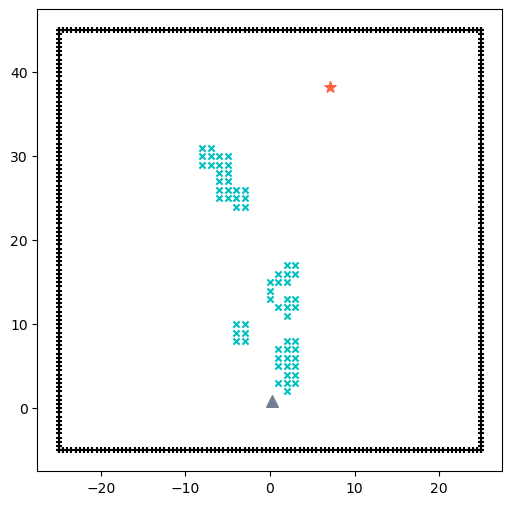

In [164]:
grid_path = os.path.join(kitti_grid_dir, "000038.json")

with open(grid_path, 'r') as f:
        grid = json.load(f)
    
mat = get_01mat_from_grid(grid)
# pr_grid = grid
pr_grid = gen_predicted_grid(torch.Tensor(mat), grid)

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

ax1.scatter(pr_grid["bx"], pr_grid["by"], marker='+', s=20, c='k')
for ox, oy in zip(pr_grid['ox'], pr_grid['oy']):
    ax1.scatter(ox, oy, marker='x', s=20, c='c')
ax1.scatter(pr_grid['sx'], pr_grid['sy'], c='slategray', marker='^',
                    s=70)  # blue start point shaped as triangle
# 2. draw goal point(the goal position)
ax1.scatter(pr_grid['tx'], pr_grid['ty'], c='tomato', marker='*', s=70)  # red goal point shaped as star

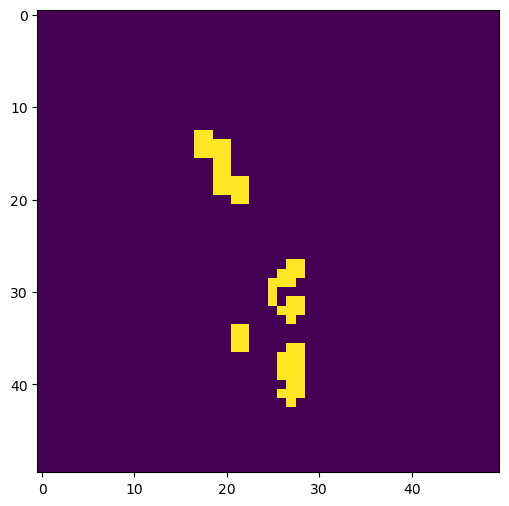

In [160]:
grid_path = os.path.join(kitti_grid_dir, "000038.json")

with open(grid_path, 'r') as f:
    grid = json.load(f)
        
mat = get_01mat_from_grid(grid)

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

ax1.imshow(mat)

## some functions

In [125]:
def flip_mat(mat, dim='x'):
    if dim == 'x':
        m = mat.shape[1]
        yidxs, xidxs = mat.nonzero()
        mat = np.zeros_like(mat)
        for i,j in zip(yidxs, xidxs):
            mat[i][m-j] = 1.
    return mat

In [141]:
def half_resolution(mat):
    mat = np.array(mat)
    m,n = mat.shape
    p,q = m//2, n//2
    mat2 = np.zeros((p,q))
    
    for i in range(p):
        for j in range(q):
            mat2[i][j] = 1. if len(mat[2*i:2*i+2, 2*j:2*j+2].nonzero()[0]) > 0 else 0.
            
    return mat2.tolist()

In [173]:
def check_collision(grid, traj, r=0.1, device='cuda:0'):
    if len(grid['ox']) == 0:  # no obstalce, so no collision
        return False
    if len(traj['pathx']) < 2:  # no solve traj, so no collision for sure
        return False

    ox, oy = [x for ox in grid['ox'] for x in ox], [y for oy in grid['oy'] for y in oy]
    px, py = traj["pathx"], traj["pathy"]

    obst_mat = torch.Tensor([ox, oy]).T.to(device)  # shape=(Nob, 2)
    traj_mat = torch.Tensor([px, py]).T.to(device)  # shape=(Ntr, 2)

    # compute the squared distance matrix between each point in the trajectory and each obstacle point on the grid with shape=(Ntr, Nob)
    square_dist_mat = torch.sum(traj_mat ** 2, dim=1, keepdim=True) + torch.sum(obst_mat ** 2, dim=1) \
                      - 2 * torch.matmul(traj_mat, obst_mat.T)

    # get the min distance between any point pairs
    min_sqdist = torch.min(square_dist_mat)  # shape=(Ntr, )

    # check if collision happens,
    # i.e. the min distance between any point pairs is lower than 2 robot radius 2r
    collided = min_sqdist < r ** 2

    return collided

In [174]:
def empty_grid_planning(grid):
    # generate the traj with empty grid
    pathx, pathy, _, _ = planner.planning(
            sx=grid['sx'], sy=grid['sy'], gx=grid['tx'], gy=grid['ty'],
            ox=grid['bx'], oy=grid['by'],
            resolution=1, rr=1, save_process=True
        )
    
    traj = {
            "pathx": pathx, "pathy": pathy,
        }
    # generate the traj 01-matrix
    grid2 = {'ox':[], 'oy':[]}
    grid2['ox'].append(traj['pathx'])
    grid2['oy'].append(traj['pathy'])
    mat = get_01mat_from_grid(grid2)
    traj['mat'] = mat
    # tell if the traj collided with the original grid
    traj['flag'] = 1 if check_collision(grid, traj) else 0
    return traj

In [235]:
def get_01mat_from_grid(grid, remove_st=False):
    xmin, xmax, ymin, ymax = -5, 5, -1, 9
    width, height = 10, 10
    mat = np.zeros((width, height))
    ox = [x for ox in grid['ox'] for x in ox]
    oy = [y for oy in grid['oy'] for y in oy]
    
    x_idx, y_idx = [], []
    
    for x,y in zip(ox, oy):
        x_idx.append(
            max(0, min(round(x-xmin), width-1))
        )
        y_idx.append(
            max(0, min(height - 1 - round(y-ymin), height-1))
        )
    
    mat[y_idx, x_idx] = 1.
    if remove_st:
        sx_idx, sy_idx = max(0, min(round(grid['sx']-xmin), width-1)), max(0, min(height - 1 - round(grid['sy']-ymin), height-1))
        tx_idx, ty_idx = max(0, min(round(grid['tx']-xmin), width-1)), max(0, min(height - 1 - round(grid['ty']-ymin), height-1))
        mat[sy_idx, sx_idx] = 0.
        mat[ty_idx, tx_idx] = 0.
    
    return mat.tolist()

In [221]:
def gen_predicted_grid(mat, gt_grid):
    threshold = 0.15

    idxs = mat.nonzero()

    pr_grid = {}
    pr_grid["sx"], pr_grid["sy"], pr_grid["tx"], pr_grid["ty"], pr_grid["bx"], pr_grid["by"] \
        = gt_grid["sx"], gt_grid["sy"], gt_grid["tx"], gt_grid["ty"], gt_grid["bx"], gt_grid["by"]
    pr_grid["ox"], pr_grid["oy"] = [], []

    xmin, ymin, xmax, ymax = -5, -1, 5, 9
    width, height = 10, 10

    ox = [xi.item() + xmin for xi in idxs[:, 1]]
    oy = [height-1 - (yi.item() - ymin) for yi in idxs[:, 0]]

    pr_grid["ox"].append(ox) 
    pr_grid["oy"].append(oy)
    
    return pr_grid

In [ ]:
def plot_grid_traj_mat(grid_mat, traj_mat, save_path=None):
    fig = plt.figure(figsize=(6, 6))
    mat = np.array(grid_mat)*0.5 + np.array(traj_mat)
    plt.imshow(mat)
    if save_path:
        plt.savefig(save_path)
        plt.close()

## result figure show

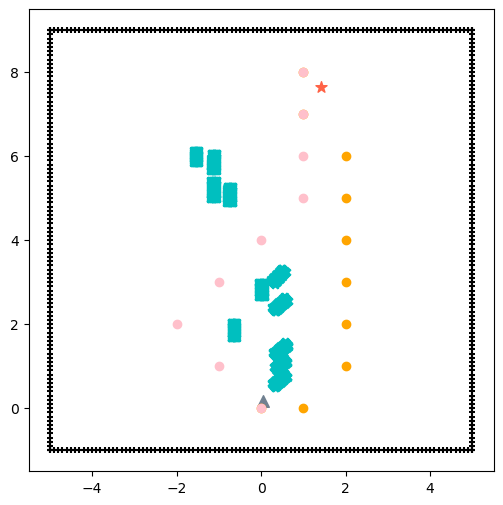

In [317]:
filename = "000038.json"
grid_path = os.path.join(kitti_grid_dir, filename)
traj_path = os.path.join(kitti_traj_dir, filename)
    
with open(grid_path, 'r') as f:
    grid = json.load(f)
with open(traj_path, 'r') as f:
    traj = json.load(f)

pr_grid = grid

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

ax1.scatter(pr_grid["bx"], pr_grid["by"], marker='+', s=20, c='k')
for ox, oy in zip(pr_grid['ox'], pr_grid['oy']):
    ax1.scatter(ox, oy, marker='x', s=20, c='c')
ax1.scatter(pr_grid['sx'], pr_grid['sy'], c='slategray', marker='^',
                    s=70)  # blue start point shaped as triangle
# 2. draw goal point(the goal position)
ax1.scatter(pr_grid['tx'], pr_grid['ty'], c='tomato', marker='*', s=70)  # red goal point shaped as star
ax1.scatter(traj['pathx'], traj['pathy'], c = 'orange')
ax1.scatter(traj['pathx2'], traj['pathy2'], c = 'pink')

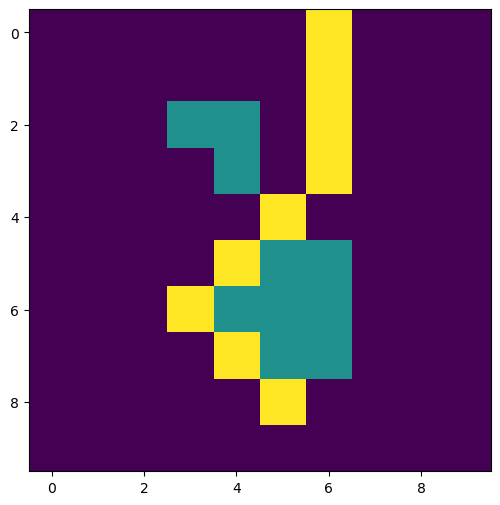

In [303]:
fig = plt.figure(figsize=(6, 6))
mat = np.array(grid['mat'])*0.5 + np.array(traj['mat'])
plt.imshow(mat)

## loss curve show

In [256]:
train_loss_curve = []
val_loss_curve = []
curve_path = "./loss_curve.json"

with open(curve_path, 'r') as f:
    curve = json.load(f)
train_loss_curve += curve["train_loss_curve"]
val_loss_curve += curve["val_loss_curve"]

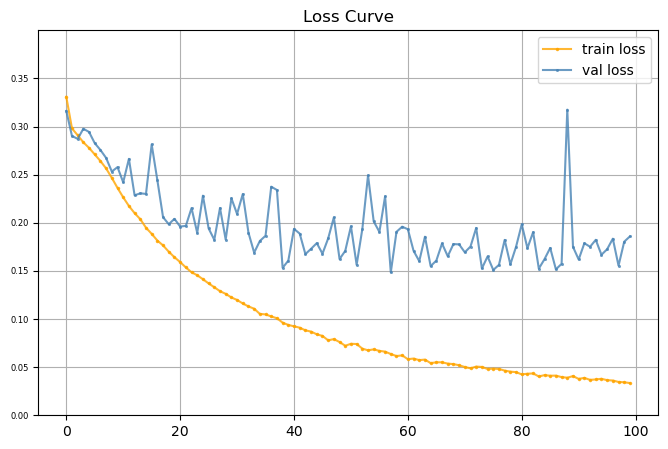

In [262]:
def draw_loss_curve(train_loss_curve, val_loss_curve):
    train_loss_curve = np.array(train_loss_curve)
    val_loss_curve = np.array(val_loss_curve)

    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)

    ax.plot(train_loss_curve[:,0], train_loss_curve[:,1], c='orange', marker='o', markersize=1.5, alpha=0.8, label="train loss")
    ax.plot(val_loss_curve[:,0], val_loss_curve[:,1], c='steelblue', marker='x', markersize=1.5, alpha=0.8, label="val loss")
    ax.set_title("Loss Curve")
    ax.grid("False")

    plt.ylim(0, 0.4)
    plt.yticks([i/20 for i in range(0, 8,)], fontsize=6)

    plt.legend(loc='best')

    save_path = "./loss_curve.png"
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    # plt.close(fig)
    plt.show()

## warcraft dataset show

In [351]:
warcraft_root = './data/warcraft_shortest_path/'
warcraft_path = os.path.join(warcraft_root, '30x30')
prefix = "train"
img_suffix = "_maps_part0"
traj_suffix = "_shortest_paths_part0"
grid_suffix = "_vertex_weights_part0"

In [352]:
imgs = np.load(os.path.join(warcraft_path, prefix + img_suffix + ".npy"))
trajs = np.load(os.path.join(warcraft_path, prefix + traj_suffix + ".npy"))
grids = np.load(os.path.join(warcraft_path, prefix + grid_suffix + ".npy"))

In [353]:
imgs.shape, trajs.shape, grids.shape

((5000, 240, 240, 3), (5000, 30, 30), (5000, 30, 30))

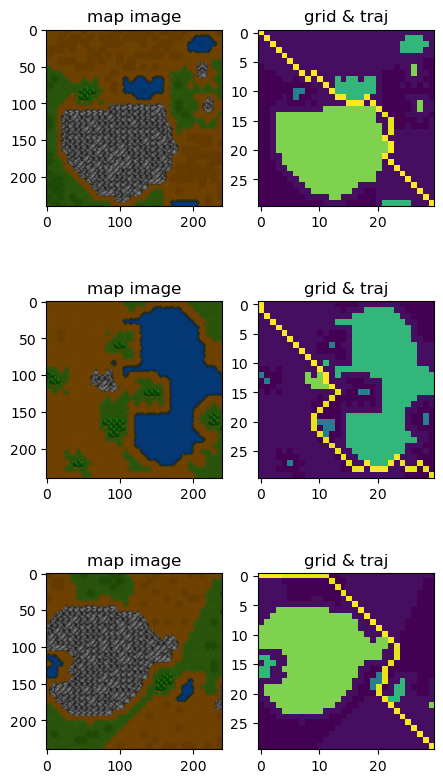

In [360]:
fig = plt.figure(figsize=(5,10))
rows = 3
idxs = np.random.randint(low=0, high=len(imgs), size=rows)

for r in range(rows):
    ax_img = fig.add_subplot(rows, 2, r*2+1)
    ax_img.set_title("map image")
    ax_img.imshow(imgs[idxs[r]].astype(np.uint8))
    ax_traj = fig.add_subplot(rows, 2, r*2+2)
    ax_traj.set_title("grid & traj")
    ax_traj.imshow(grids[idxs[r]] + trajs[idxs[r]]*10)
    
fig.subplots_adjust(hspace=0.2)
plt.show()

## paper figure plot function

In [345]:
def plot(grid, trajs, figsize=(6,6), times=1, sample_ratio=100):
    """
    draw several trajs on the grid, but currently trajs only contain at most two trajs
    one is ground-truth traj, the other is predicted traj
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import make_interp_spline
    
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)

    ## draw grid
    bx, by, oxs, oys, sx, sy, tx, ty = (
        np.array(grid['bx'])*times, np.array(grid['by'])*times, 
        np.array(grid['ox'])*times, np.array(grid['oy'])*times, 
        np.array(grid['sx'])*times, np.array(grid['sy'])*times,
        np.array(grid['tx'])*times, np.array(grid['ty'])*times,
                                       )
    
    # black boundary as cross
    ax1.scatter(bx, by, marker='+', s=20, c='k')
    # other colors as X
    for ox, oy in zip(oxs, oys):
        ax1.scatter(ox, oy, marker='x', s=20)
    # blue start point shaped as triangle
    ax1.scatter(sx, sy, c='slategray', marker='^', s=70)  
    # red goal point shaped as star
    ax1.scatter(tx, ty, c='tomato', marker='*', s=70)  
    
    ## draw trajactory
    labels = ['ground-truth', 'predicted']
    clist = ['darkorange', 'steelblue'] # now only support 2 trajs
    for i, traj in enumerate(trajs):
        px, py = np.array(traj['pathx'])*times, np.array(traj['pathy'])*times
        if len(px) == 1: # no path
            continue
        while py[0] > ty: # get rid of the waypoints that overhead the target point 
            px, py = px[1:], py[1:]
        px, py = px[:-1], py[:-1]
        # create an interpolation function f
        wx, wy = np.append(np.append(px, sx)[::-1], tx), np.append(np.append(py, sy)[::-1], ty) # waypoints
        param = np.linspace(0, 1, wy.size) # parameterized  input
        f = make_interp_spline(param, np.c_[wy, wx], k=2) # function
        cx, cy = f(np.linspace(0, 1, wy.size * sample_ratio)).T # output 
            
        # draw waypoints
        ax1.scatter(px, py, alpha=0.6, c=clist[i%len(clist)])
        # draw connecting plots
        ax1.plot(cy, cx, '-', alpha=0.7, c=clist[i%len(clist)], label=labels[i%len(labels)])
        
    # draw legend
    plt.legend(loc=(0.64, 0.83))

In [346]:
def test_plot(idx=0):
    filename = ("000000" + str(idx))[-6:] + ".json"
    grid_path = os.path.join(kitti_grid_dir, filename)
    traj_path = os.path.join(kitti_traj_dir, filename)

    with open(grid_path, 'r') as f:
        grid = json.load(f)
    with open(traj_path, 'r') as f:
        traj = json.load(f)

    traj2 = {
        "pathx": traj['pathx2'], "pathy": traj['pathy2']
    }
    trajs = [traj, traj2]
    plot(grid, trajs, figsize=(6,6), times=10, sample_ratio=100,)

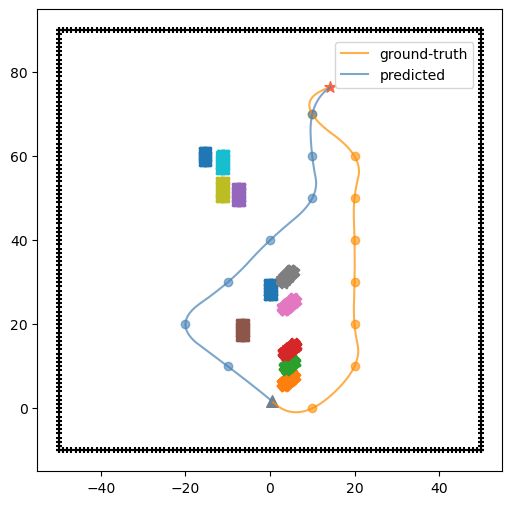

In [349]:
test_plot(38)

## paper table results

In [38]:
import pandas as pd
df = pd.DataFrame({
    "description": ["solving", "solving", "stronger baseline", "stronger baseline", 
                    "weaker baseline", "weaker baseline", "supervised perception", "supervised perception"],
    "precision": [0.0634, 0.0643, 0.7434, 0.5217, 0.6519, 0.4793, 0.8499, 0.7498],  
    "recall": [1.0, 1.0, 0.8054, 0.6024, 0.7218, 0.5651, 0.8484, 0.7425],
    "collision rate": [1.0, 0.9150, 0.3680, 0.6383, 0.54, 0.6817, 0.2831, 0.5293],
    "length diff": [None, 100.0, 2.8924, 2.9401, 2.9174, 3.6073, 2.7550, 2.9084],
    "non-solved/total": [None, None, None, None, None, None, "16/500", "20/600"],
}, index=[
    # fully over-fitting and useless
    "recurrent transformer trained with only solving traj on kitti",
    "recurrent transformer trained with only solving traj on nuscenes",
    # stronger baseline
    "recurrent transformer trained with 01 traj on kitti",
    "recurrent transformer trained with 01 traj on nuscenes",
    # weaker baseline
    "resnet18 trained with 01 traj  on kitti",
    "resnet18 trained with 01 traj on nuscenes",
    # supervised perception
    "resnet 18 trained with 01 grid on kitti",
    "resnet 18 trained with 01 grid on nuscenes",
])
df

,description,precision,recall,collision rate,length diff,non-solved/total
recurrent transformer trained with only solving traj on kitti,solving,0.0634,1.0000,1.0000,NaN,None
recurrent transformer trained with only solving traj on nuscenes,solving,0.0643,1.0000,0.9150,100.0000,None
recurrent transformer trained with 01 traj on kitti,stronger baseline,0.7434,0.8054,0.3680,2.8924,None
recurrent transformer trained with 01 traj on nuscenes,stronger baseline,0.5217,0.6024,0.6383,2.9401,None
resnet18 trained with 01 traj on kitti,weaker baseline,0.6519,0.7218,0.5400,2.9174,None
resnet18 trained with 01 traj on nuscenes,weaker baseline,0.4793,0.5651,0.6817,3.6073,None
resnet 18 trained with 01 grid on kitti,supervised perception,0.8499,0.8484,0.2831,2.7550,16/500
resnet 18 trained with 01 grid on nuscenes,supervised perception,0.7498,0.7425,0.5293,2.9084,20/600


In [39]:
def f1(p, r):
    return (2*p*r)/(p+r)

In [40]:
f1_scores = []
for i, row in df.iterrows():
    f1_scores.append(f1(row['precision'],row['recall']))
df['f1'] = f1_scores
df = df.reindex(columns=["description", "precision", "recall", "f1", "collision rate", "length diff", "non-solved/total"])
df

,description,precision,recall,f1,collision rate,length diff,non-solved/total
recurrent transformer trained with only solving traj on kitti,solving,0.0634,1.0000,0.119240,1.0000,NaN,None
recurrent transformer trained with only solving traj on nuscenes,solving,0.0643,1.0000,0.120831,0.9150,100.0000,None
recurrent transformer trained with 01 traj on kitti,stronger baseline,0.7434,0.8054,0.773159,0.3680,2.8924,None
recurrent transformer trained with 01 traj on nuscenes,stronger baseline,0.5217,0.6024,0.559153,0.6383,2.9401,None
resnet18 trained with 01 traj on kitti,weaker baseline,0.6519,0.7218,0.685072,0.5400,2.9174,None
resnet18 trained with 01 traj on nuscenes,weaker baseline,0.4793,0.5651,0.518676,0.6817,3.6073,None
resnet 18 trained with 01 grid on kitti,supervised perception,0.8499,0.8484,0.849149,0.2831,2.7550,16/500
resnet 18 trained with 01 grid on nuscenes,supervised perception,0.7498,0.7425,0.746132,0.5293,2.9084,20/600
